In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmaps

from plot_Spikingmodel import *
from params import params
from brian2 import *
from analyse_experiment import *

In [2]:
%matplotlib inline

# Load data

In [3]:
result_path = './results/retrain_results_tuned1_2.pkl'

with open(result_path, 'rb') as f:
    results = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './results/retrain_results_tuned0_2.pkl'

In [ ]:
run_nos = np.arange(1, 2).astype(str)
no_stimuli = params['N4']
N_pyr = params['NPYR']
N_pop = 4
N_sst = params['NSOM']
N_pv = params['NPV']
N_vip = params['NVIP']
seed = params['seed']
nonplasticwarmup = params['nonplasticwarmup_simtime'] / second
plasticwarmup = params['warmup_simtime'] / second
rewardsimtime = params['reward_simtime'] / second
norewardsimtime = params['noreward_simtime'] / second
noSSTPVsimtime = params['noSSTPV_simtime'] / second
gmax = params['gmax']
input_time = params['input_time'] / second
warmup = nonplasticwarmup + plasticwarmup
total = warmup + rewardsimtime + norewardsimtime + nonplasticwarmup + noSSTPVsimtime 

t = np.arange(.0, 135.3, .0001) * second


In [ ]:
dep_param = np.zeros(len(run_nos))
dep_param2 = np.zeros(len(run_nos))
performance = np.zeros(len(run_nos))
performance_binary = np.zeros(len(run_nos))
W_sst_pv = np.zeros((len(run_nos), N_sst * N_pv))
W_pyr = np.zeros((len(run_nos), N_pyr * N_pyr))
W_pyr_i = np.zeros((len(run_nos), N_pyr * N_pyr))
W_pyr_j = np.zeros((len(run_nos), N_pyr * N_pyr))
con_SOM_VIP_i = np.zeros((len(run_nos), N_sst * N_vip))
con_SOM_VIP_j = np.zeros((len(run_nos), N_sst * N_vip))
con_VIP_SOM_i = np.zeros((len(run_nos), N_vip * N_sst))
con_VIP_SOM_j = np.zeros((len(run_nos), N_vip * N_sst))
r_pyr = np.zeros((len(run_nos), N_pyr))
rel_select_increase_mean = np.zeros((len(run_nos)))
rel_select_increase = np.zeros((len(run_nos), N_pop))
resp_increase = np.zeros((len(run_nos), N_pop))
rel_resp_increase = np.zeros((len(run_nos), N_pop))
response_rel_to_max = np.zeros((len(run_nos), N_pop))
response_rel_to_max_before = np.zeros((len(run_nos), N_pop))
response = np.zeros((len(run_nos), N_pop))
increase = np.zeros((len(run_nos), N_pop))
simple_resp_increase = np.zeros((len(run_nos), N_pop))
SST0_PVmean = np.zeros((len(run_nos)))
SSTother_PVmean = np.zeros((len(run_nos)))
impact = np.zeros((len(run_nos)))
impact_afterreward = np.zeros((len(run_nos)))
impactmax = np.zeros((len(run_nos)))
impactmax_afterreward = np.zeros((len(run_nos)))
sst_pv = np.zeros((len(run_nos)))
tuning = np.zeros((len(run_nos)))
SOM0VIPprob = np.zeros((len(run_nos), int(N_sst / 30)))
VIPSOM0prob = np.zeros((len(run_nos), int(N_sst / 30)))
W_sst_pv_means = np.zeros((len(run_nos), N_pop))
W_sst_pv_std = np.zeros((len(run_nos), N_pop))
W_sst_pv_means_afterreward = np.zeros((N_pop))
W_sst_pv_std_afterreward = np.zeros((N_pop))
varied_param2 = 'tau_spikelet'
varied_param = 'p_PV_PYR'
plt.set_cmap(cmaps.viridis)
checker = None

<Figure size 432x288 with 0 Axes>

# Plot strength

In [ ]:
PYR1toothers = results['PYR1toothers'][:]
otherstoPYR1 = results['otherstoPYR1'][:]
PYR0toothers = results['PYR0toothers'][:]
PYR2toothers = results['PYR2toothers'][:]
PYR3toothers = results['PYR3toothers'][:]
PYR023toothers = np.concatenate((PYR0toothers, PYR2toothers, PYR3toothers))

In [ ]:
def tsplot(data, **kw):
    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    plt.fill_between(x, cis[0], cis[1], alpha=0.2, **kw)
    plt.plot(x, est, **kw, lw=2)
    plt.margins(x=0)

Text(900, 0.25, 'Refinement\n Phase')

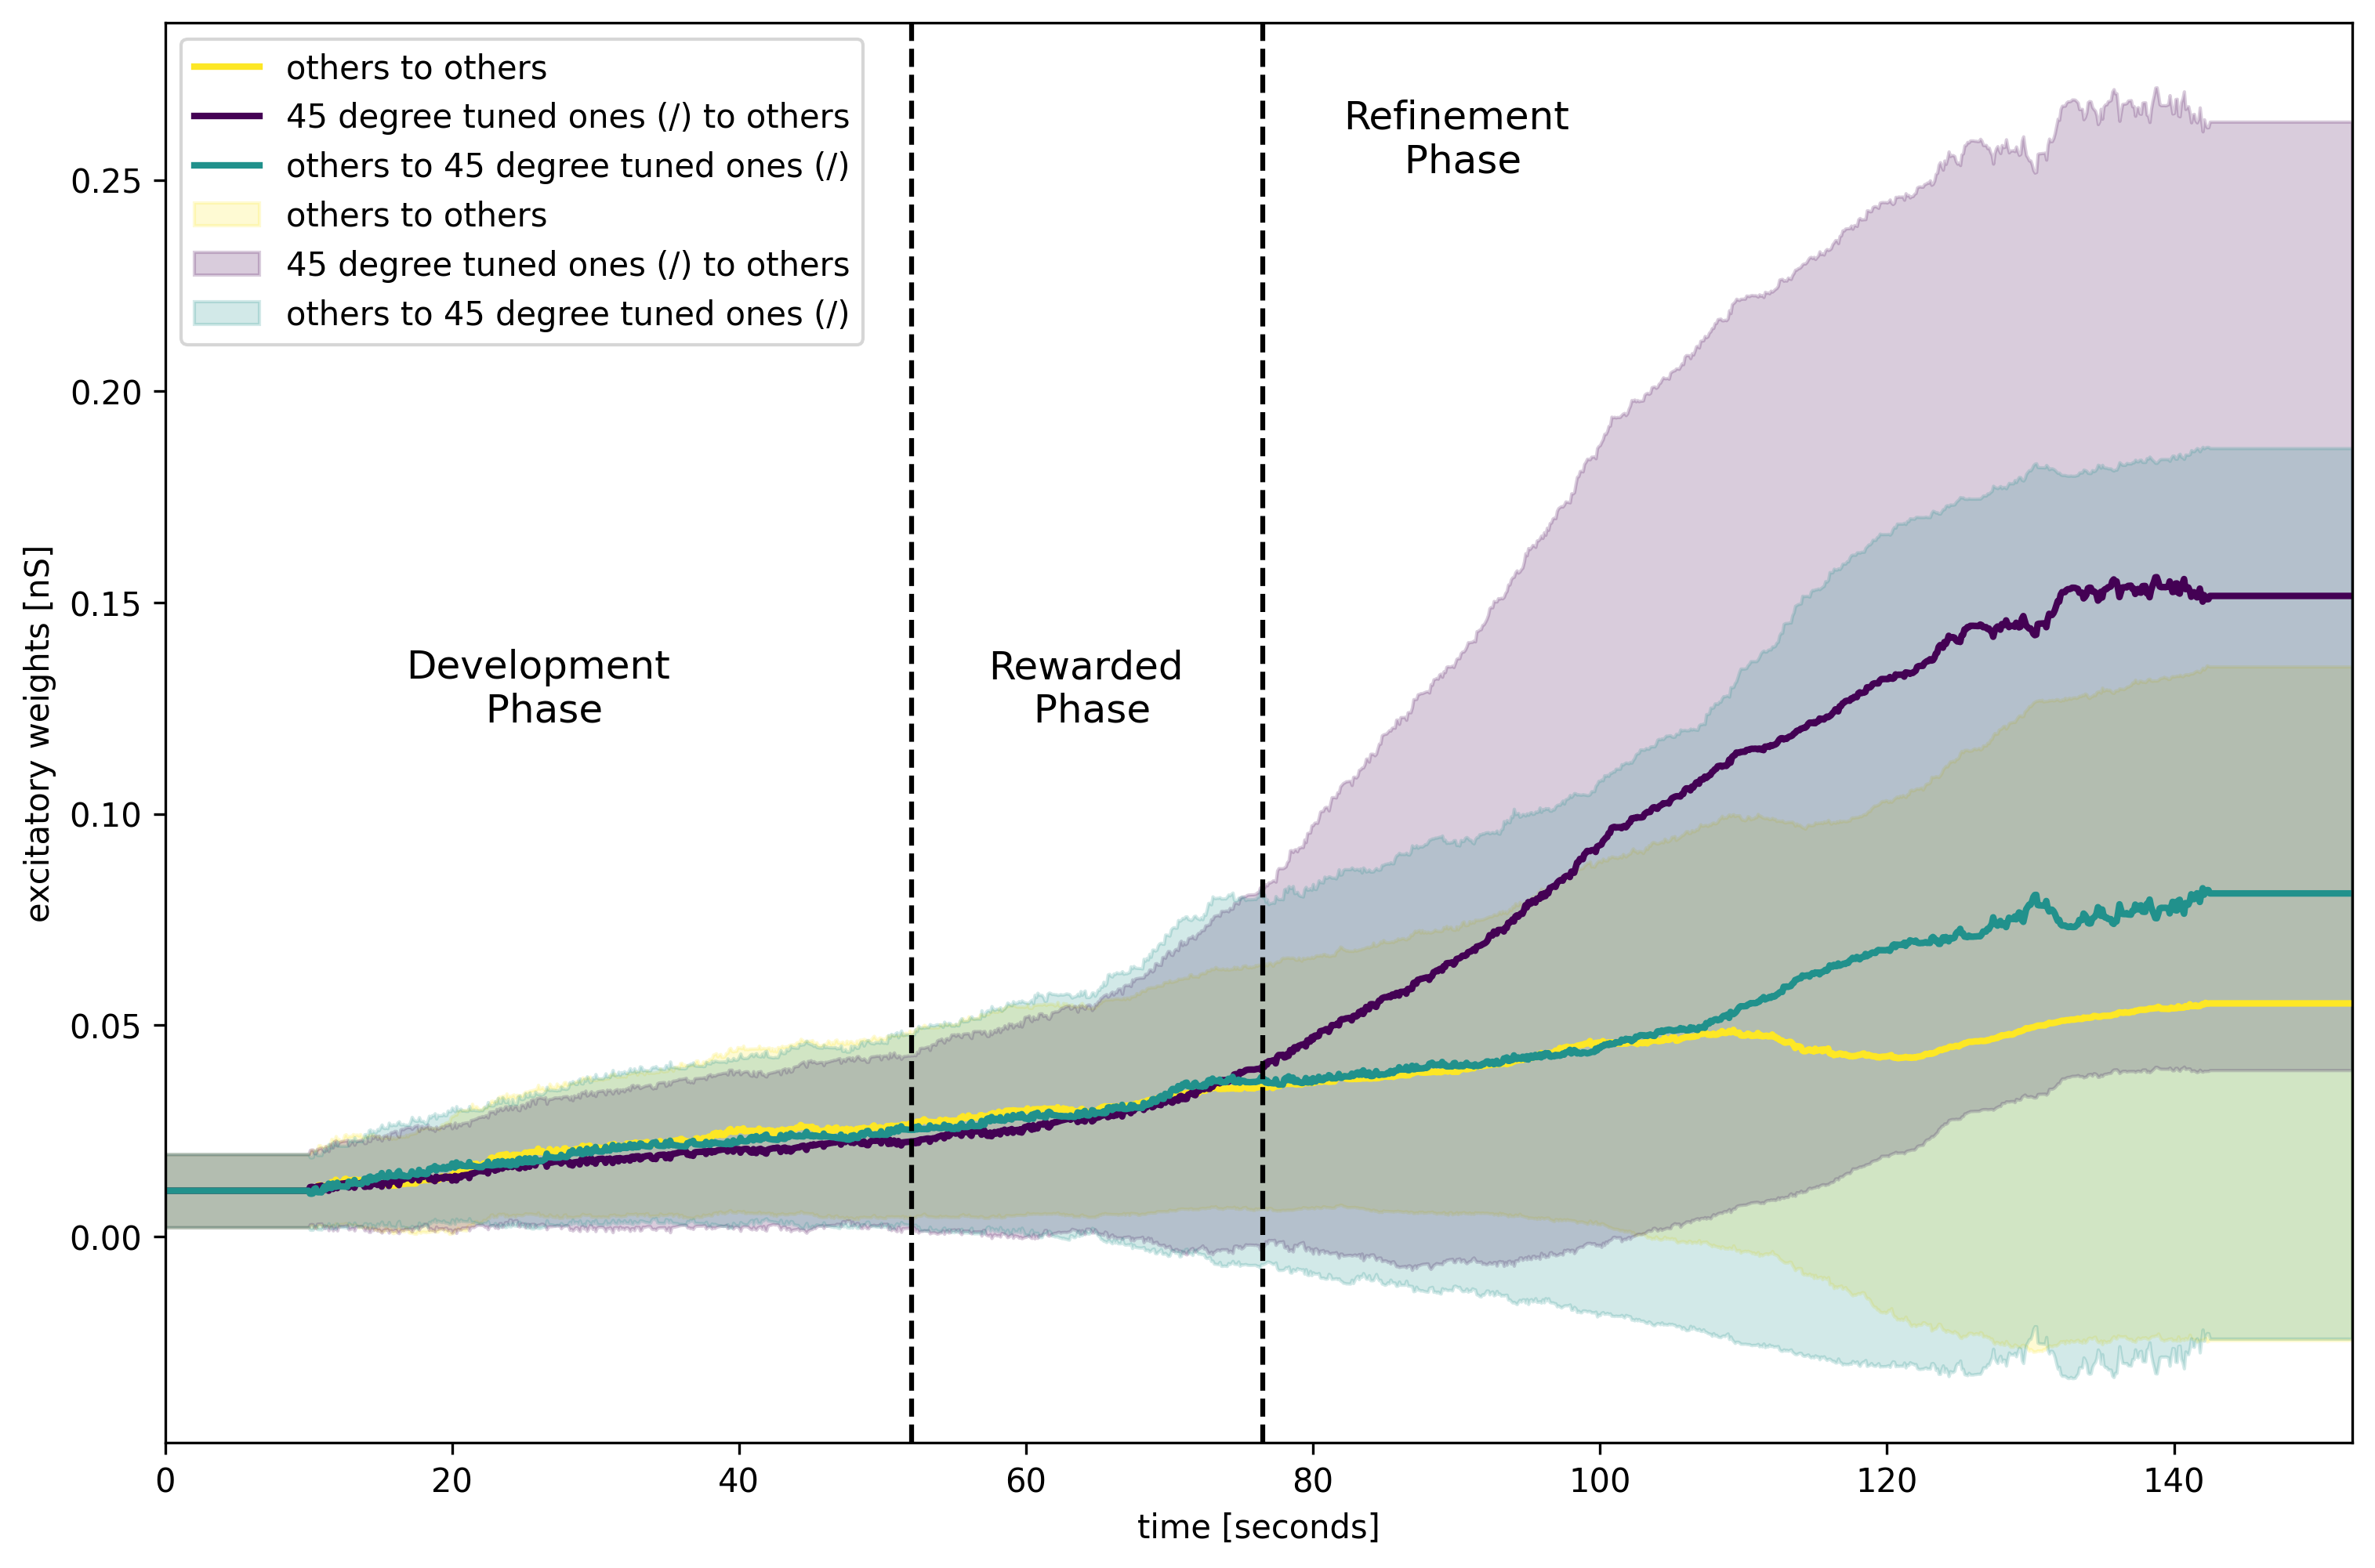

In [ ]:
plt.figure(figsize=(12, 8), dpi = 300)
tsplot(data=PYR023toothers[:, :] / nS, color=cmaps.viridis(1.0)  ,label='others to others')
tsplot(data=PYR1toothers[:, :] / nS, color=cmaps.viridis(0.0)  ,label ='45 degree tuned ones (/) to others')
tsplot(data=otherstoPYR1[:, :] / nS, color=cmaps.viridis(0.5)  ,label='others to 45 degree tuned ones (/)')
plt.xlabel('time [seconds]')
plt.ylabel('excitatory weights [nS]')
plt.xticks(np.arange(0, total * 10, 200), labels=np.arange(0, int(total), 20))
plt.legend(loc='upper left')
plt.axvline(x=warmup*10, color='k', linestyle='--')
plt.axvline(x=(warmup + rewardsimtime)*10, color='k', linestyle='--')
plt.text(warmup*10/2, 0.12, 'Development\n Phase', verticalalignment='bottom', horizontalalignment='center', fontsize=12)
plt.text(warmup*10+rewardsimtime*10//2, 0.12, 'Rewarded\n Phase', verticalalignment='bottom', horizontalalignment='center', fontsize=12)
plt.text(900, 0.25, 'Refinement\n Phase', verticalalignment='bottom', horizontalalignment='center', fontsize=12)


# Plot for tuning curve

In [ ]:
def plot_tuningcurves(tunings_initial,
                      tuning_rewardend,
                      tuning_after_rewardend,
                      tunings_final,
                      N_neurons=400,
                      N_pop=4,
                      save=None,
                      name=''):
    ymax = 4
    fig = plt.figure(figsize=(14, 12),dpi=300)  # 4.2, 3
    if name == '':
        max = 4
    groupsize = N_neurons / N_pop
    titles = ['|', '/', '——', '\\']
    for k in range(0, N_neurons, int(groupsize)):
        if N_pop > 1:
            plt.subplot(N_pop / 2, N_pop / 2, (k / groupsize) + 1)

        plt.plot(np.arange(np.shape(tunings_initial)[1]),
                 np.mean(tunings_initial[k:int(k + groupsize), :], 0),
                 'k',
                 lw=3,
                 label='before')

        if not tuning_rewardend is None:
            plt.plot(np.arange(np.shape(tunings_initial)[1]),
                     np.mean(tuning_rewardend[k:int(k + groupsize), :], 0),
                     color=cmaps.magma(0.2),
                     lw=3,
                     label='before end of rewarded phase')
            plt.title('/')
        if not tuning_after_rewardend is None:
            plt.plot(np.arange(np.shape(tunings_initial)[1]),
                     np.mean(tuning_after_rewardend[k:int(k + groupsize), :],
                             0),
                     color=cmaps.viridis(0.5),
                     lw=3,
                     label='after rewarded phase')
        if not tunings_final is None:
            plt.plot(np.arange(np.shape(tunings_initial)[1]),
                     np.mean(tunings_final[k:int(k + groupsize), :], 0),
                     color=cmaps.magma(0.7),
                     lw=3,
                     label='after refinement phase')
        plt.title(titles[int(k / groupsize)])
        plt.xticks(np.arange(0,
                             np.shape(tunings_initial)[1]),
                   ('|', '/', '——', '\\'))
        plt.yticks(np.arange(0, ymax + 1, 2))
        plt.legend()

    plt.xlabel('orientation')
    plt.ylabel('firing rate')

## PC tuning curve

In [ ]:
tunings_initial = results['tuning_initial']
tuning_rewardend = results['tuning_rewardend']
tuning_after_rewardend = results['tuning_after_rewardend']
tunings_final = results['tuning_final']

WARNING    <ipython-input-10-d5e5a0098106>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(N_pop / 2, N_pop / 2, (k / groupsize) + 1)
 [py.warnings]
  plt.subplot(N_pop / 2, N_pop / 2, (k / groupsize) + 1)

WARNING    <ipython-input-10-d5e5a0098106>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(N_pop / 2, N_pop / 2, (k / groupsize) + 1)
 [py.warnings]
  plt.subplot(N_pop / 2, N_pop / 2, (k / groupsize) + 1)

WARNING    <ipython-input-10-d5e5a0098106>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(N_pop / 2, N_pop / 2, (k / groupsize) + 1)
 [py.warnings]
  plt.subplot(N_pop / 2, N_pop / 2, (k / gro

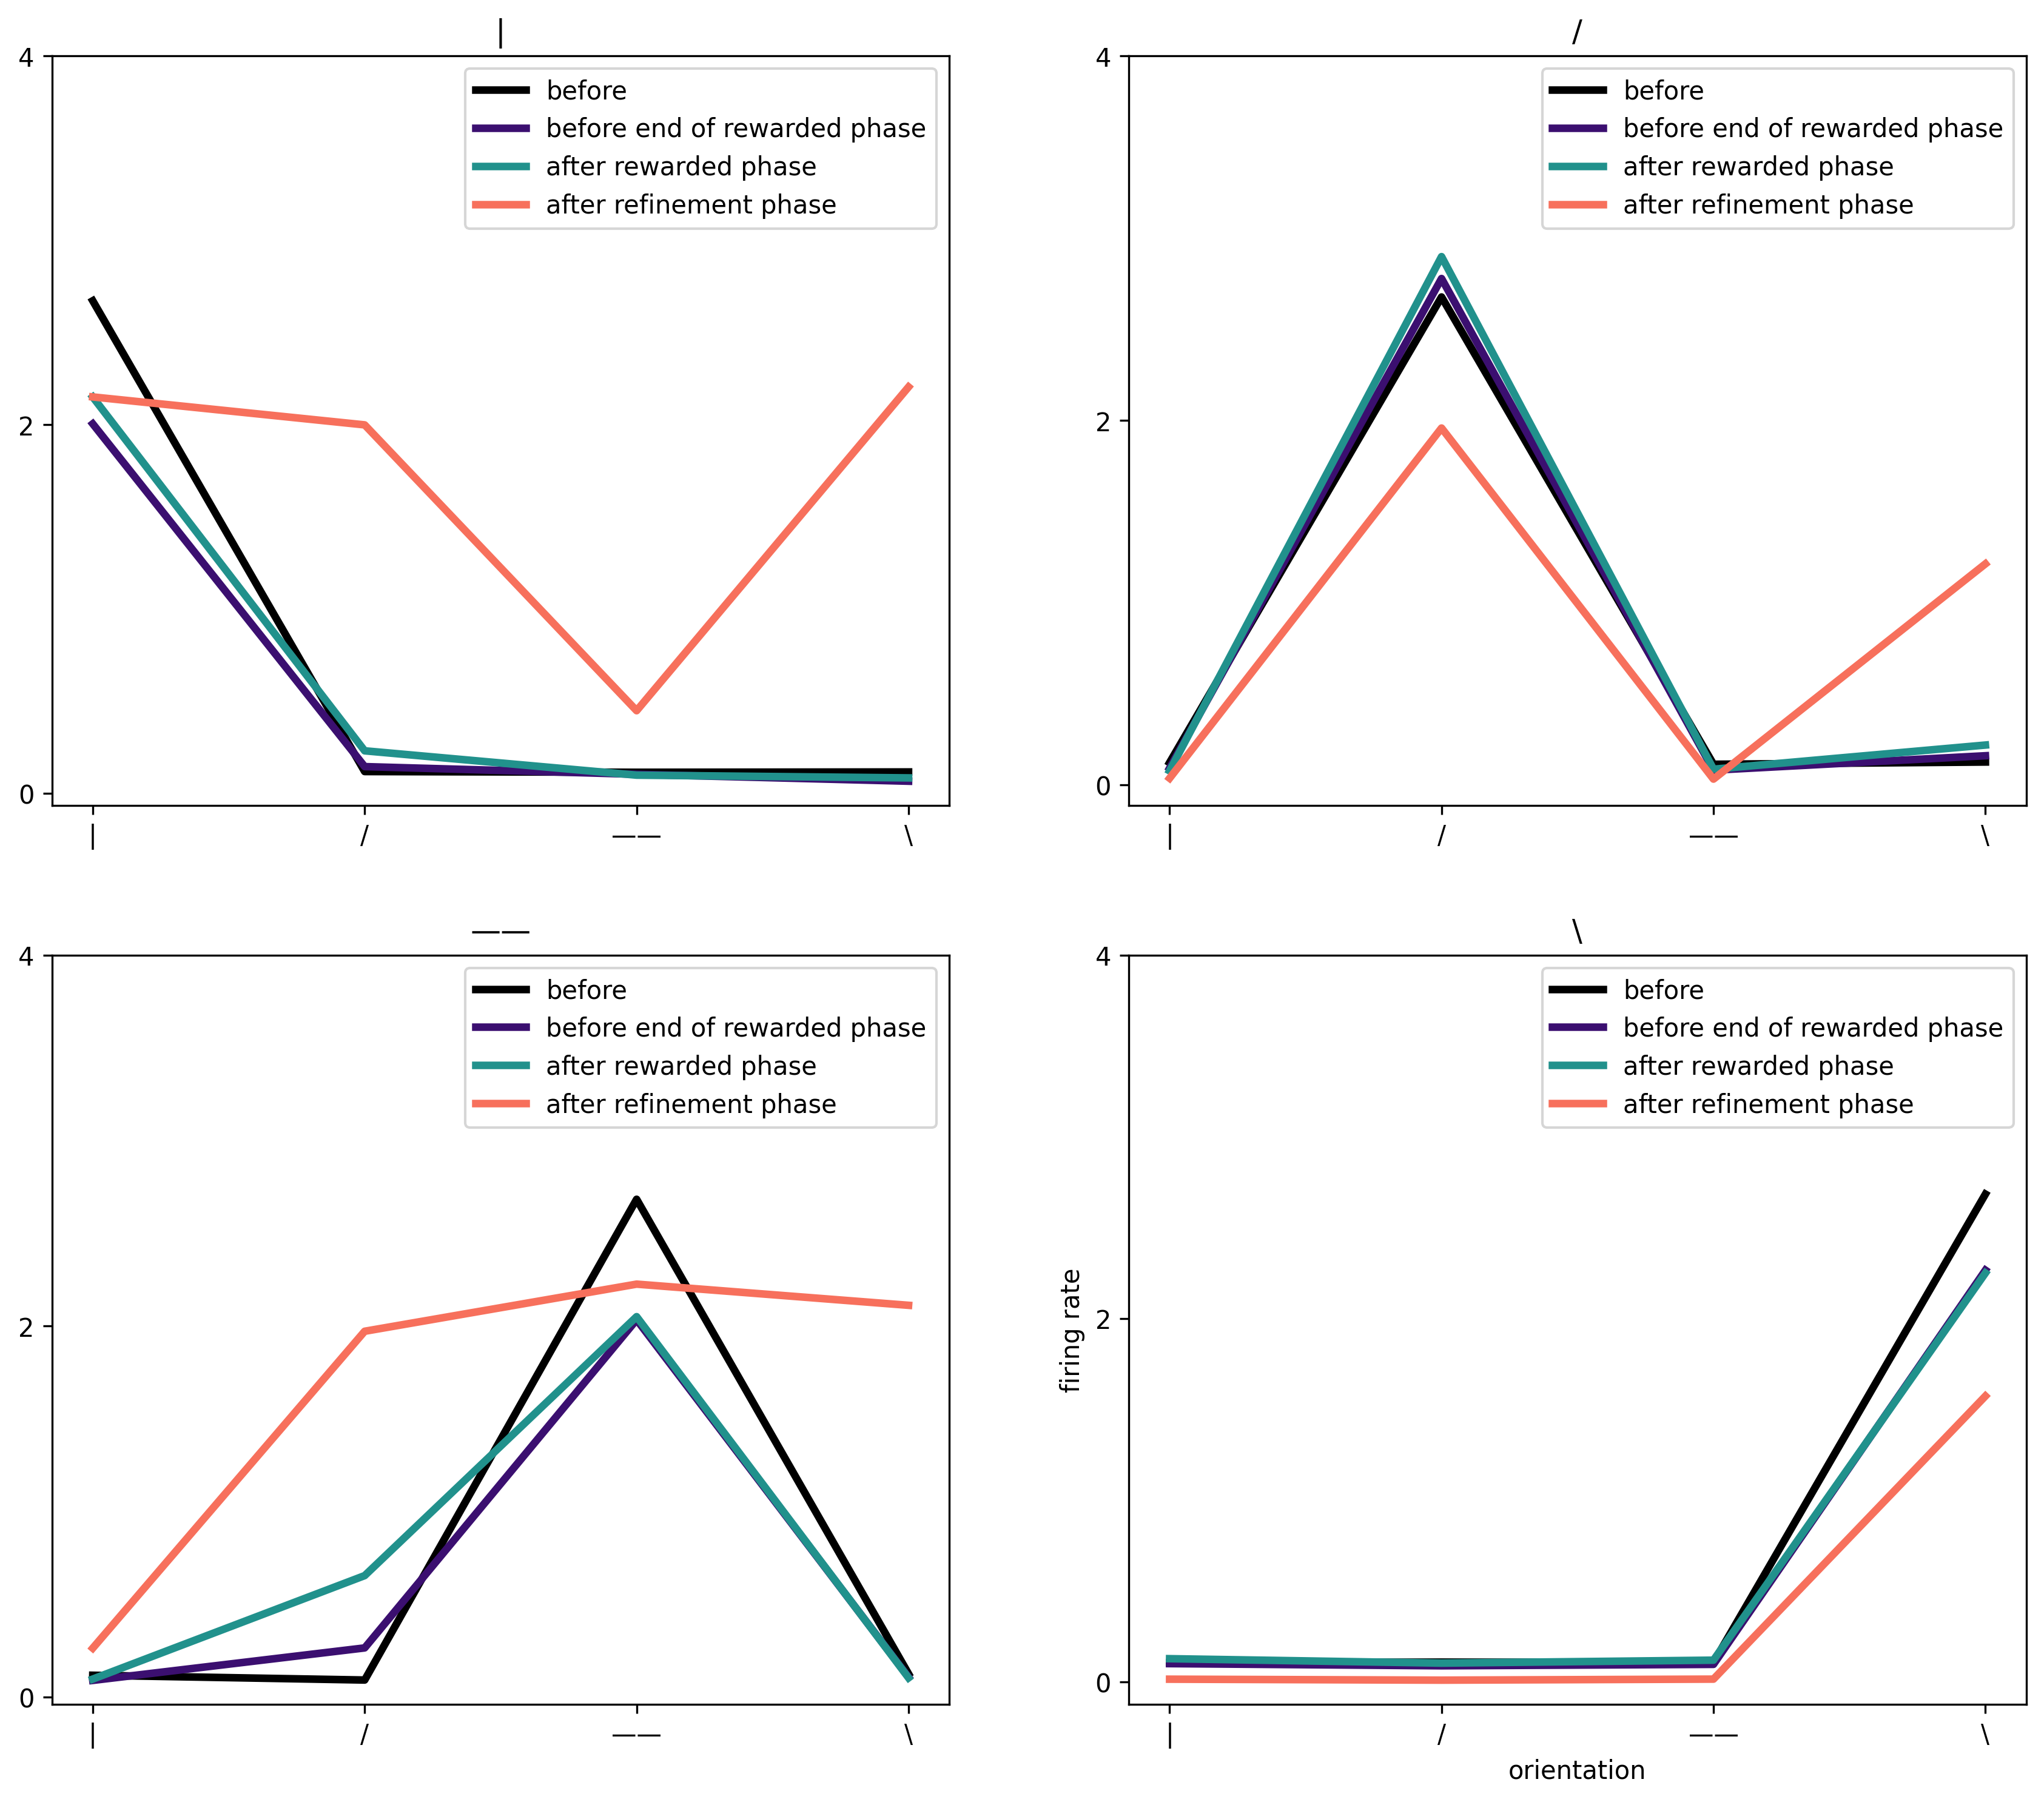

In [ ]:
plot_tuningcurves(tunings_initial, tuning_rewardend, tuning_after_rewardend, tunings_final, N_pop=4, N_neurons=400)

## PV tuning curve

In [ ]:
pv_tunings_initial = results['PVtuning_initial']
pv_tuning_rewardend = results['PVtuning_rewardend']
pv_tuning_after_rewardend = results['PVtuning_after_rewardend']
pv_tunings_final = results['PVtuning_final']

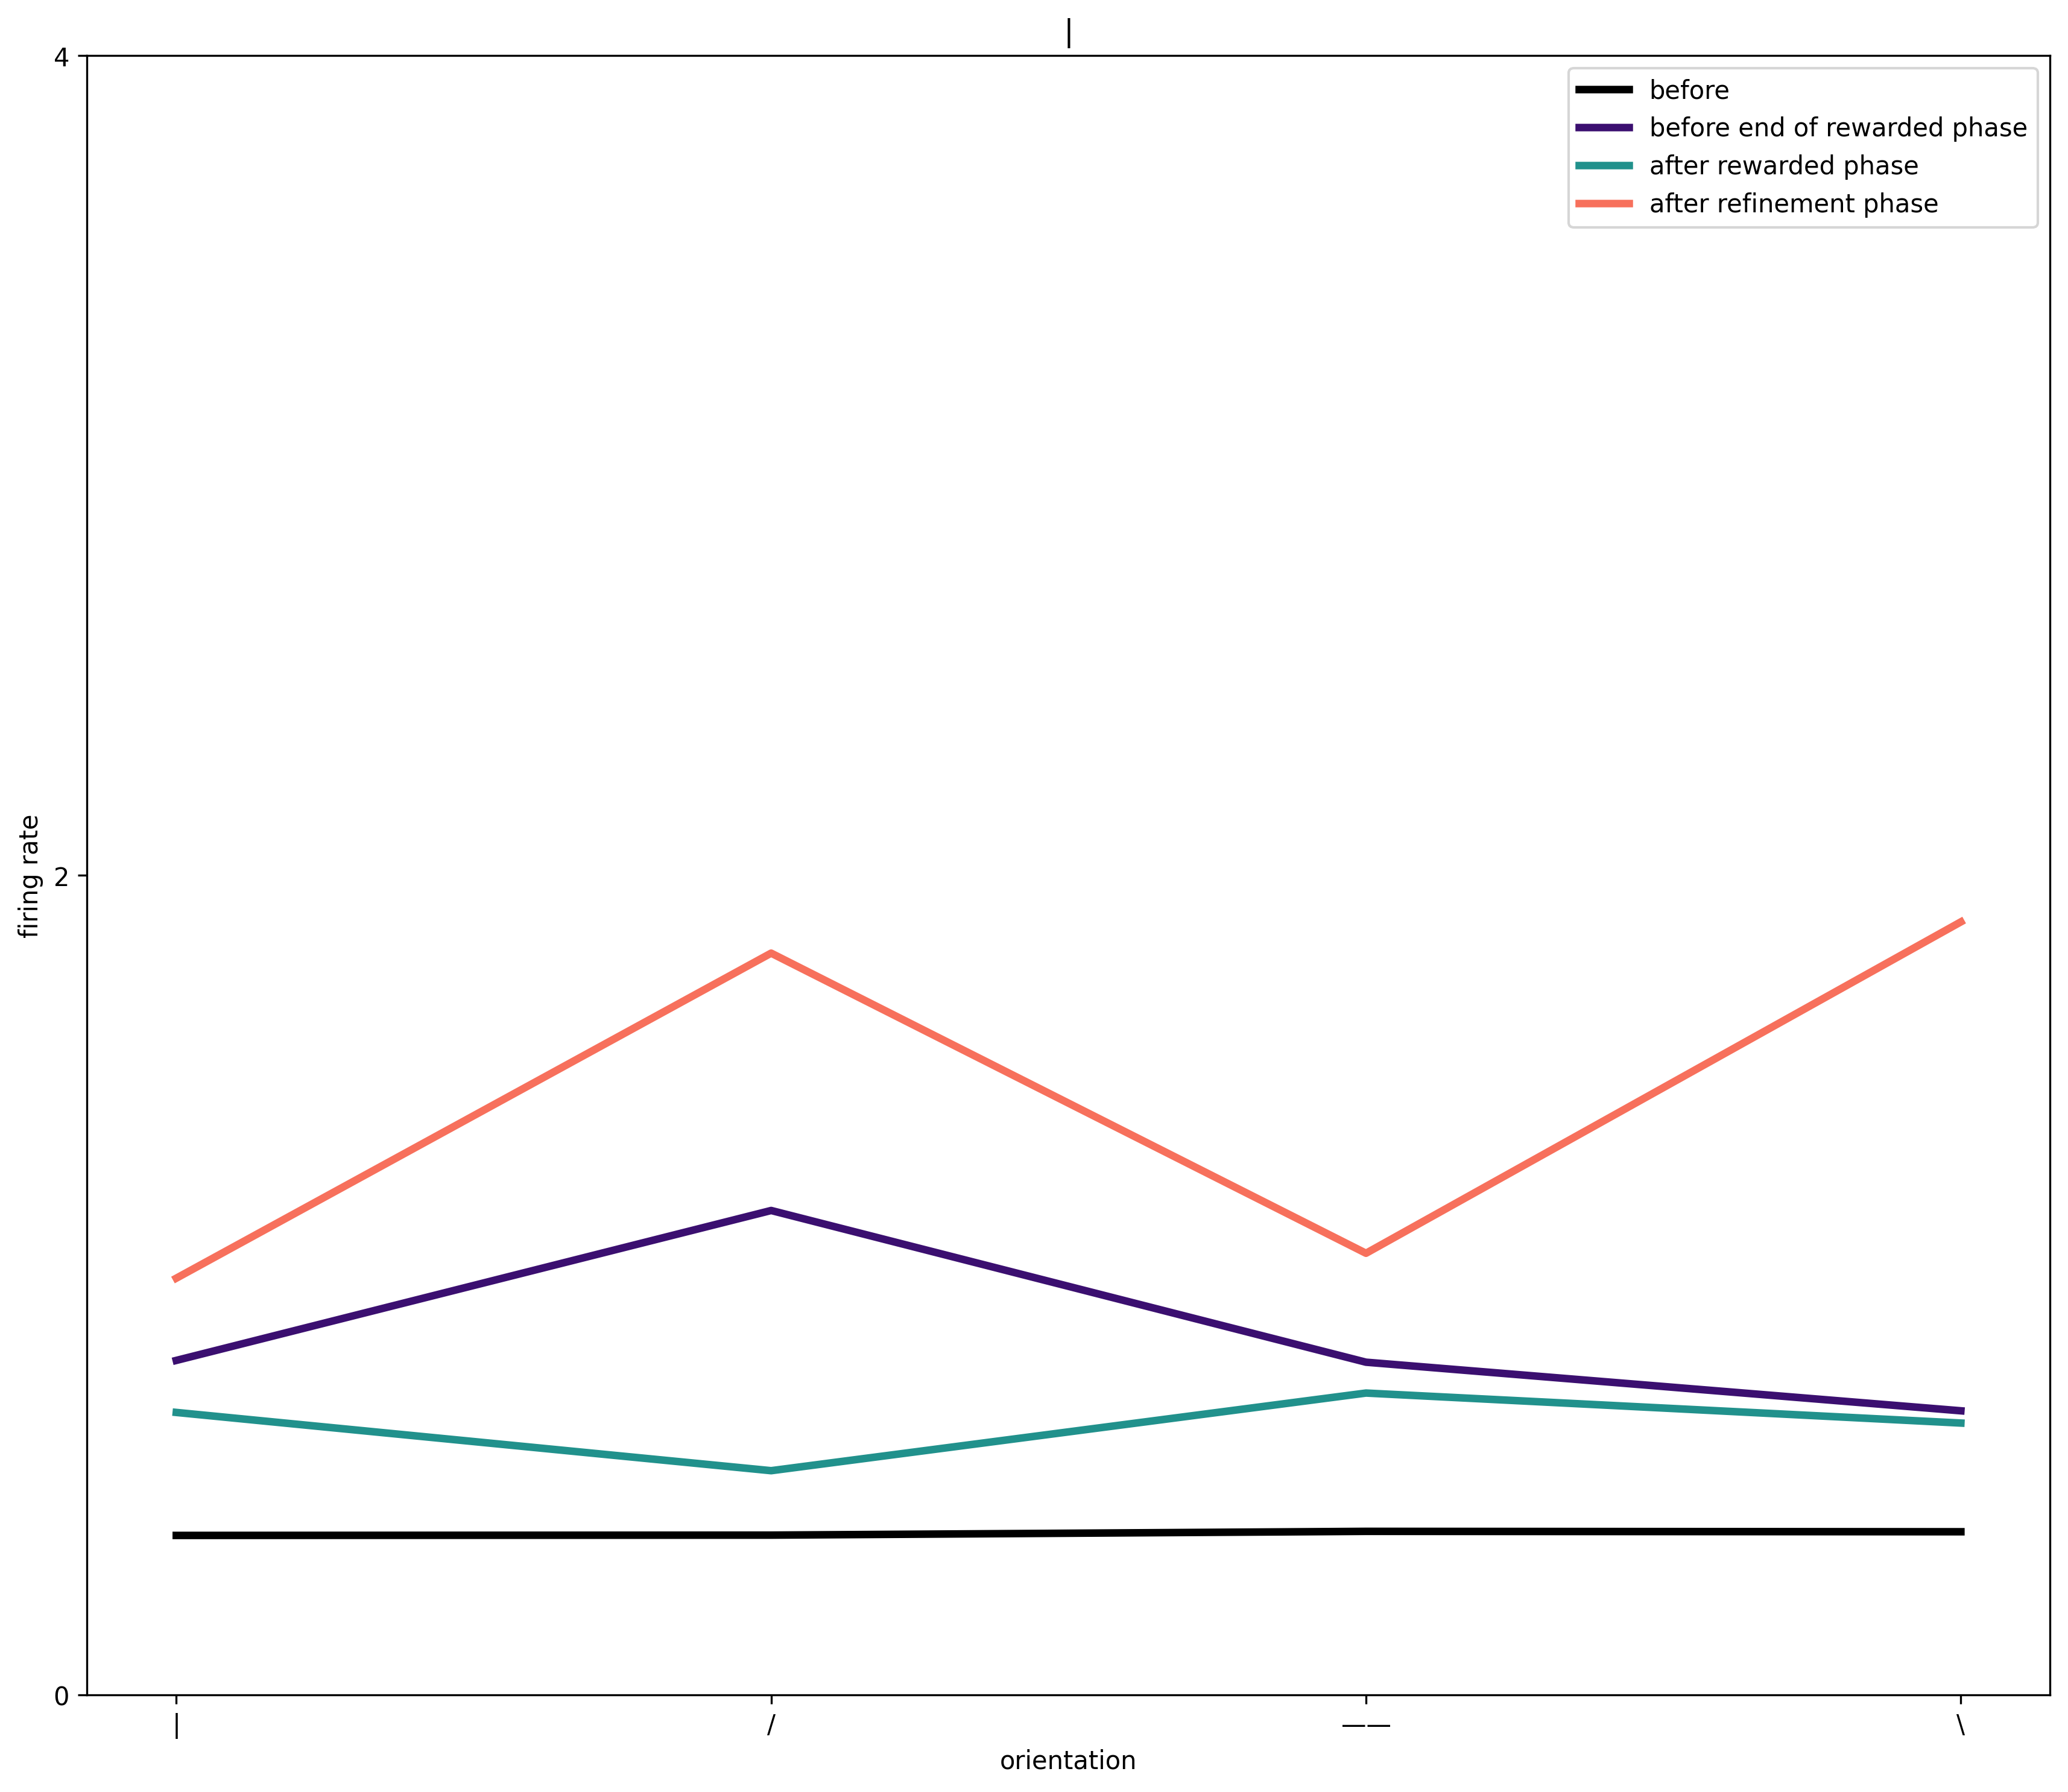

In [ ]:
plot_tuningcurves(pv_tunings_initial, pv_tuning_rewardend, pv_tuning_after_rewardend, pv_tunings_final, N_pop=1, N_neurons=120)

## SST tuning curve

In [ ]:
sst_tunings_initial = results['SOMtuning_initial']
sst_tuning_rewardend = results['SOMtuning_rewardend']
sst_tuning_after_rewardend = results['SOMtuning_after_rewardend']
sst_tunings_final = results['SOMtuning_final']

WARNING    <ipython-input-10-d5e5a0098106>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(N_pop / 2, N_pop / 2, (k / groupsize) + 1)
 [py.warnings]
  plt.subplot(N_pop / 2, N_pop / 2, (k / groupsize) + 1)

WARNING    <ipython-input-10-d5e5a0098106>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(N_pop / 2, N_pop / 2, (k / groupsize) + 1)
 [py.warnings]
  plt.subplot(N_pop / 2, N_pop / 2, (k / groupsize) + 1)

WARNING    <ipython-input-10-d5e5a0098106>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(N_pop / 2, N_pop / 2, (k / groupsize) + 1)
 [py.warnings]
  plt.subplot(N_pop / 2, N_pop / 2, (k / gro

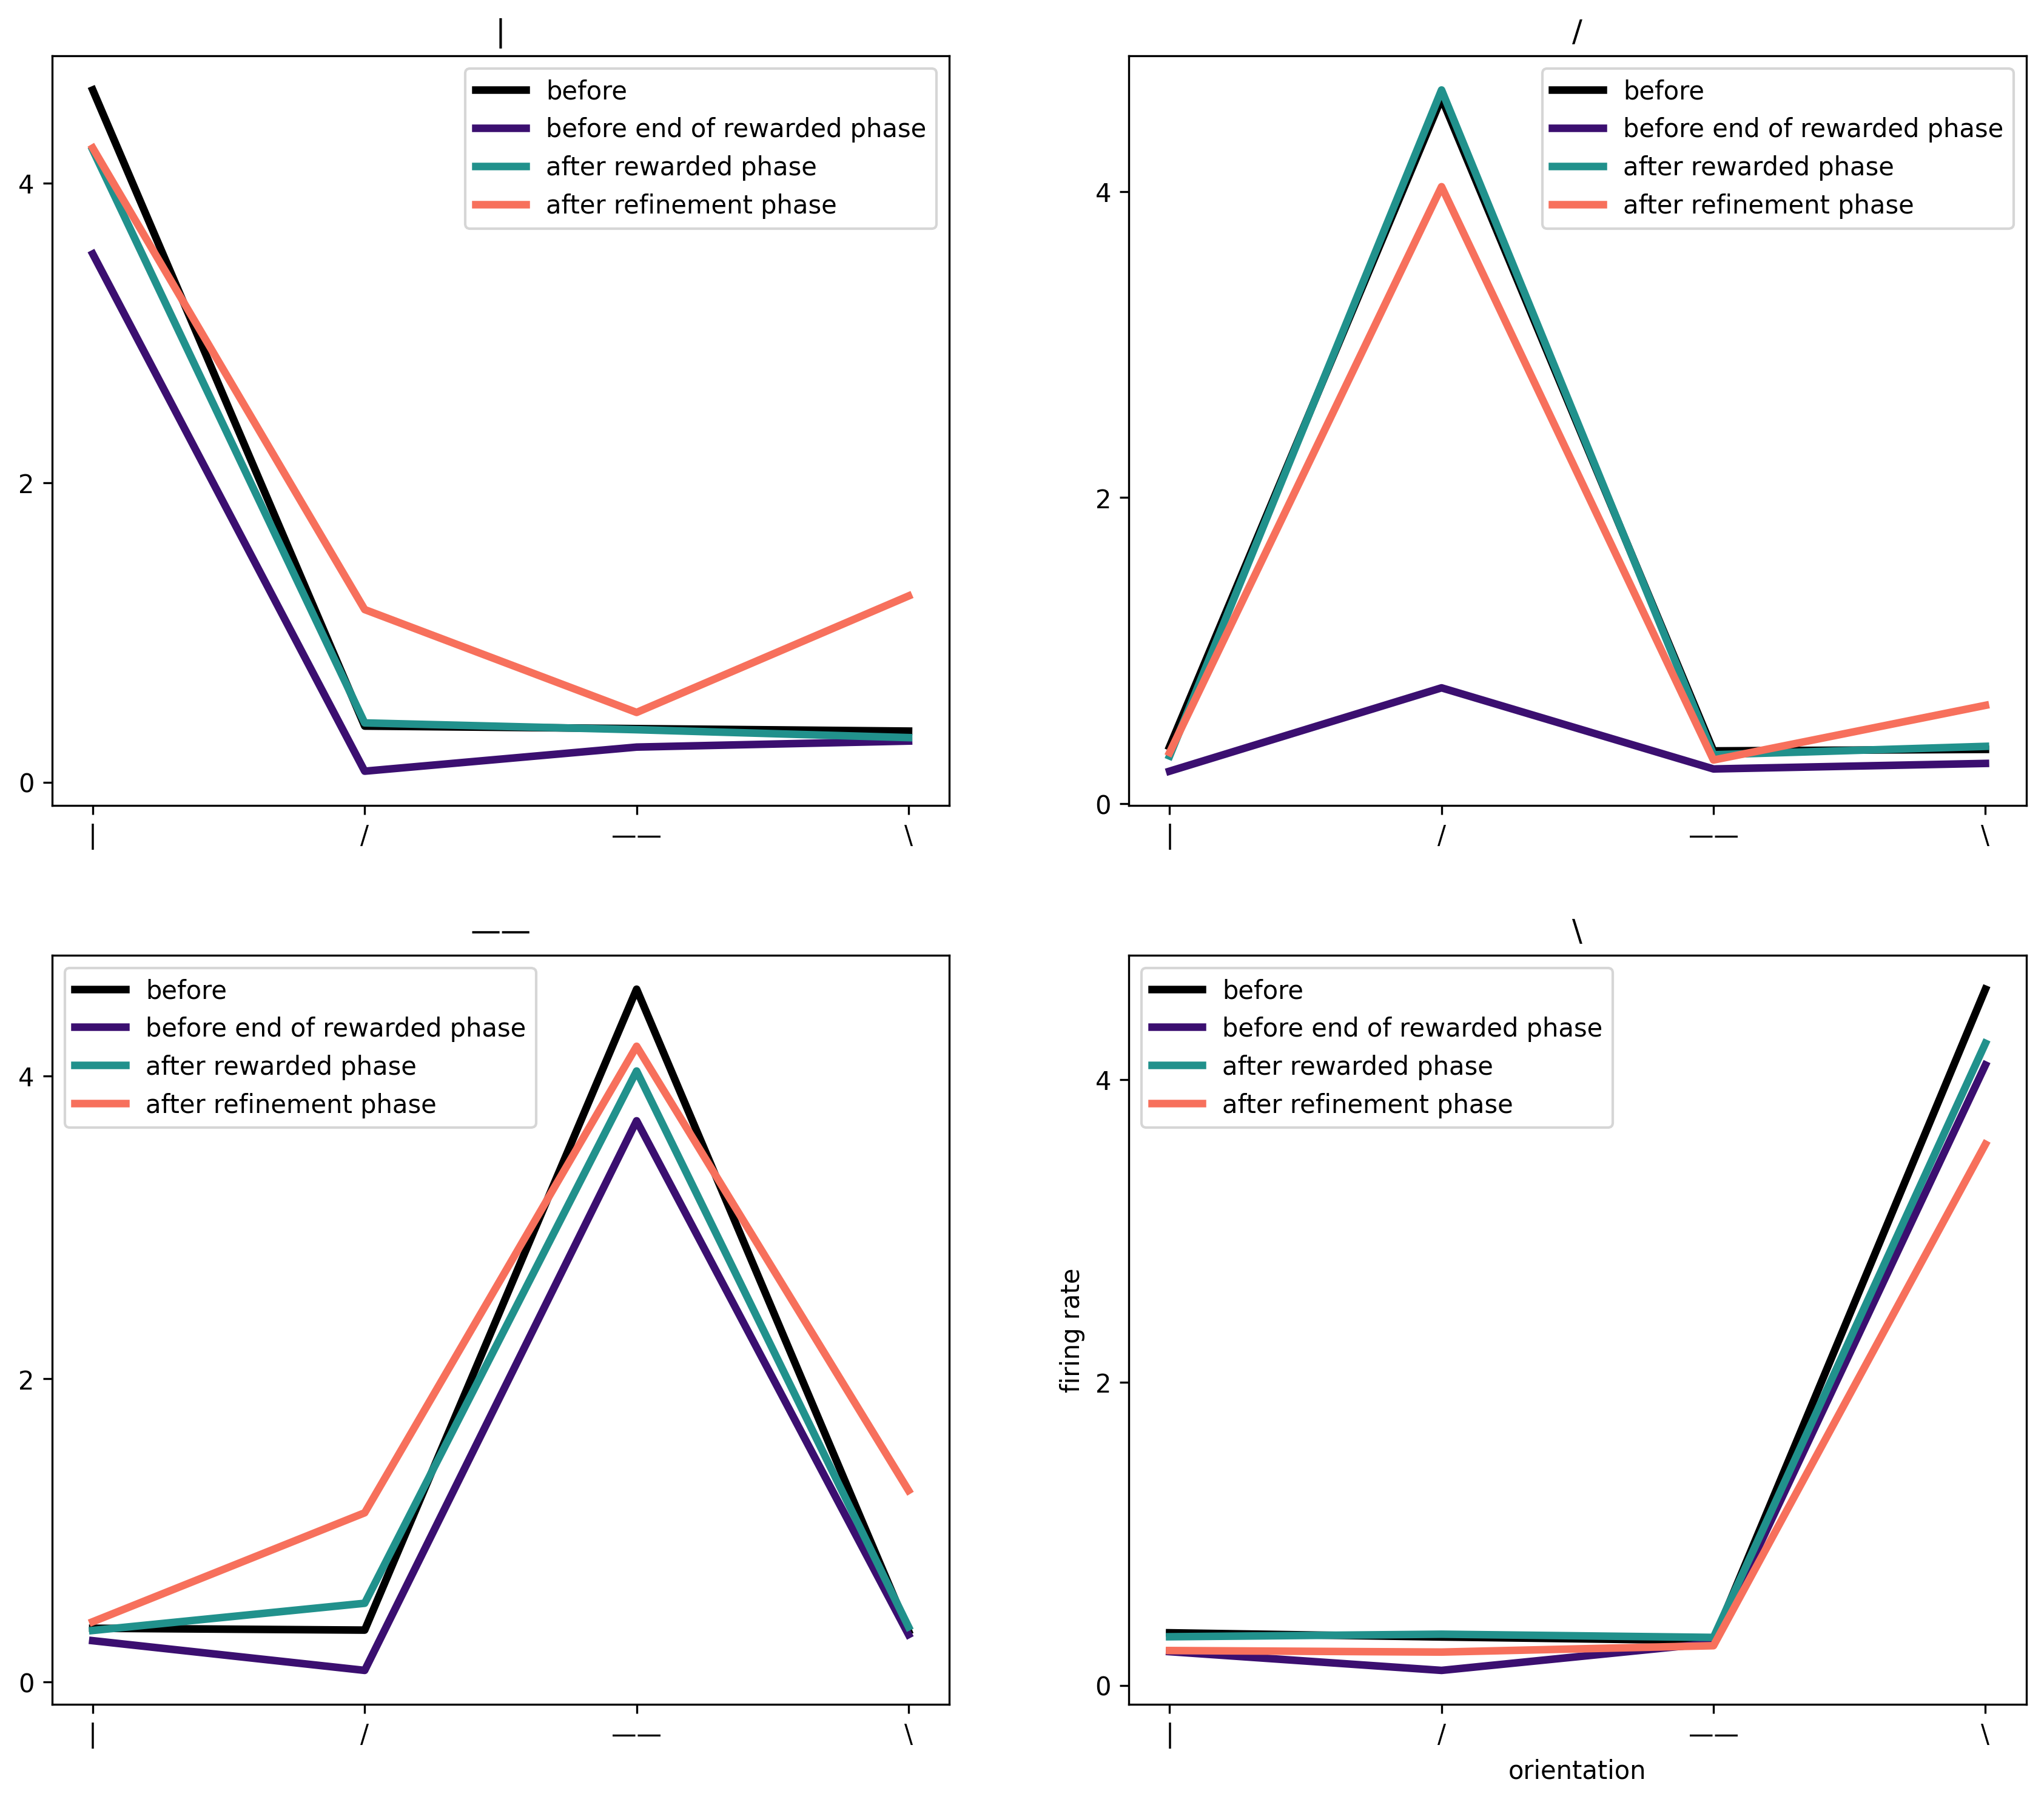

In [ ]:
plot_tuningcurves(sst_tunings_initial, sst_tuning_rewardend, sst_tuning_after_rewardend, sst_tunings_final, N_pop=4, N_neurons=120)

# VIP tuning curve

In [ ]:
vip_tunings_initial = results['VIPtuning_initial']
vip_tuning_rewardend = results['VIPtuning_rewardend']
vip_tuning_after_rewardend = results['VIPtuning_after_rewardend']
vip_tunings_final = results['VIPtuning_final']

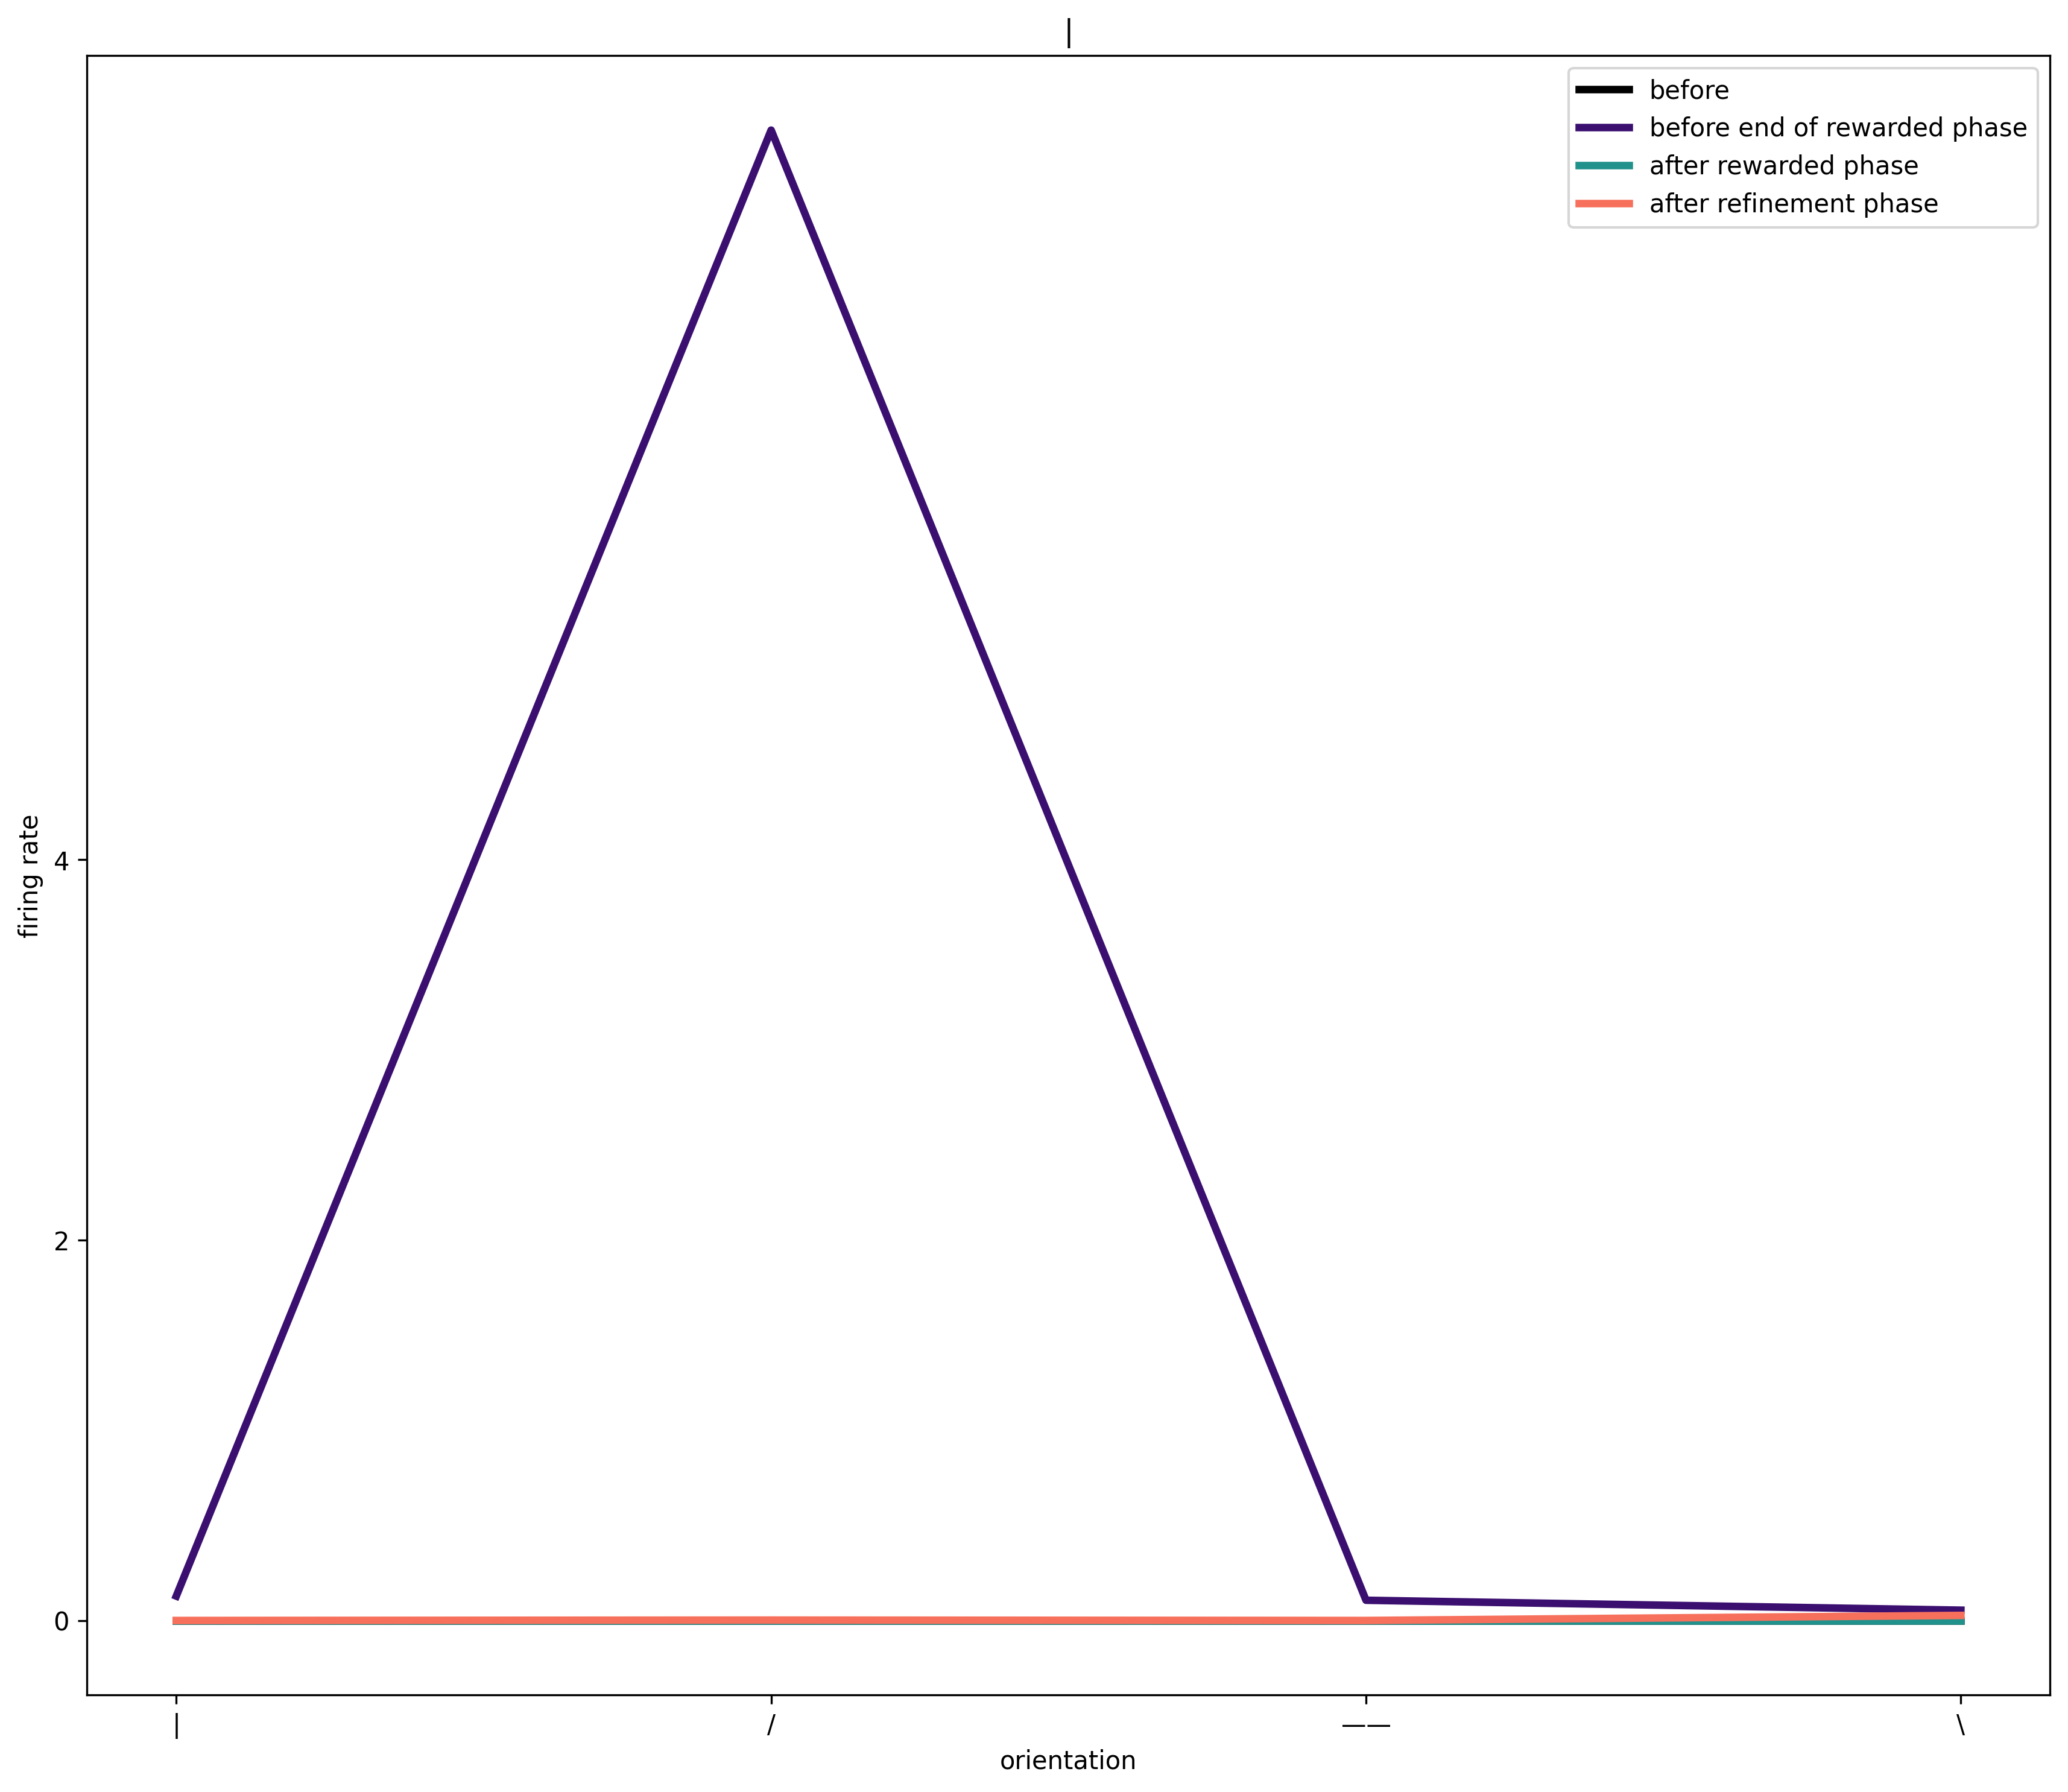

In [ ]:
plot_tuningcurves(vip_tunings_initial, vip_tuning_rewardend, vip_tuning_after_rewardend, vip_tunings_final, N_pop=1, N_neurons=50)

## L4 tuning curve

In [ ]:
N4 = params['N4']
L4_rate = params['L4_rate'] / Hz

In [ ]:
symbols = ['|', '/', '——', '\\']
orientations = {symbols[i]: i/(1.0*4)*pi for i in range(4)}
selectivities = {symbols[i]: (i%N4)/(1.0*N4)*pi for i in range(4)}

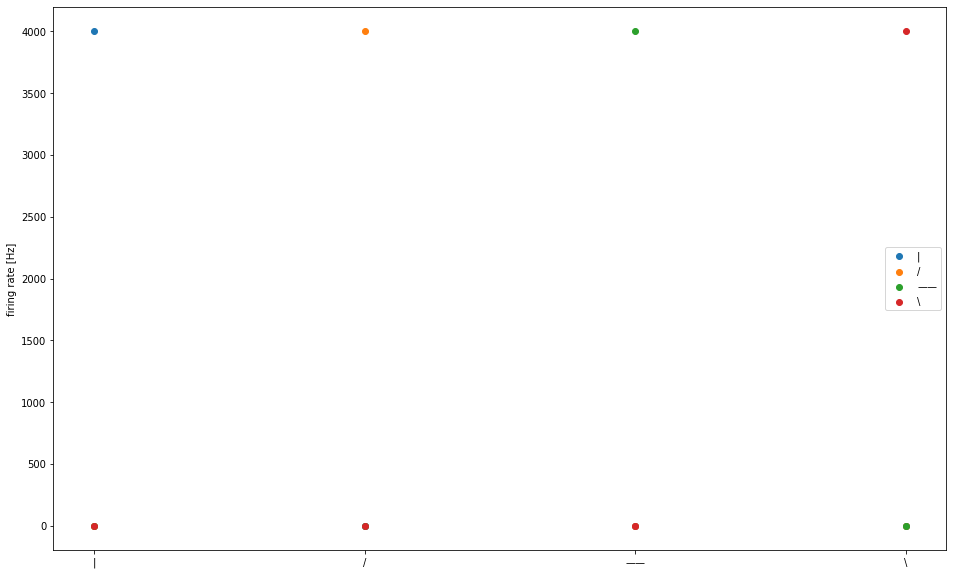

In [ ]:
fig = plt.figure(figsize=(16, 10))

for prefered_symbol in symbols:
    selectivity = selectivities[prefered_symbol]
    rate = [clip(cos(orientations[symbol]*2 - selectivity*2), 0, inf)*L4_rate for symbol in symbols]
    plt.scatter(np.arange(4), rate, label=prefered_symbol)
    

plt.xticks(np.arange(4), symbols)
plt.ylabel('firing rate [Hz]')
plt.legend()

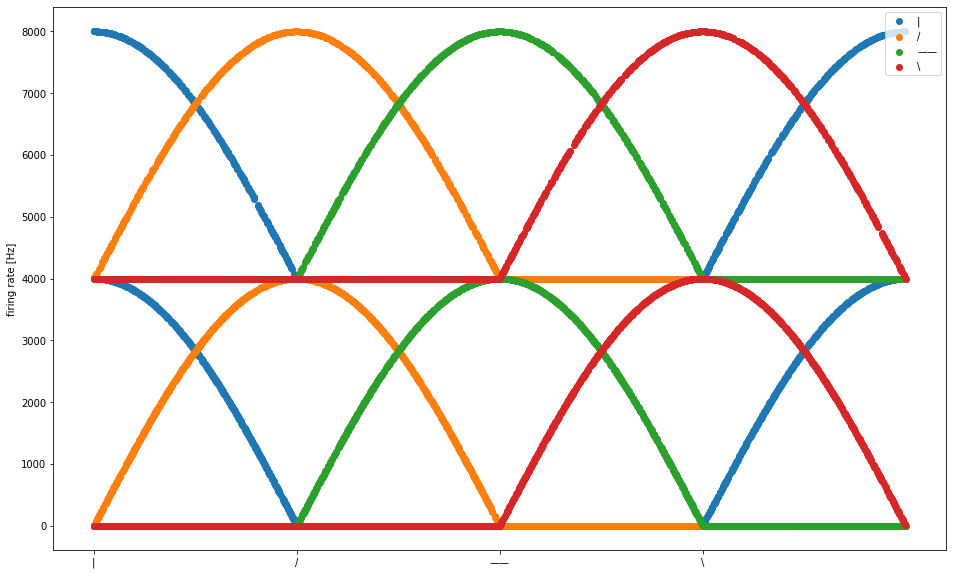

In [ ]:
fig = plt.figure(figsize=(16, 10))
num_sim = 3000
for prefered_symbol in symbols:
    selectivity = selectivities[prefered_symbol]
    rate = [clip(cos(orientation/num_sim*pi*2 - selectivity*2), 0, inf)*L4_rate + int(rand()<L4_rate*1e-4)*L4_rate for orientation in range(0, num_sim+1)]
    plt.scatter(np.arange(num_sim+1)/num_sim*pi, rate, label=prefered_symbol)
    

plt.xticks(np.arange(4)/4*pi, symbols)
plt.ylabel('firing rate [Hz]')
plt.legend()